======input picture========


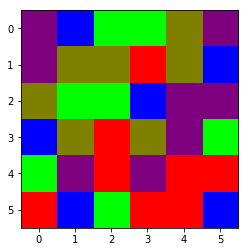

=======output picture========

========15000 epochs after=========


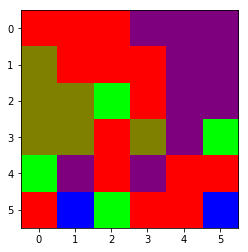

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random

#parameters
DESIGN_PARAMS_NUM=5#設計変数の数
DESIGN_NUM=5#設計した個体数
epochs=15000#学習回数
output_size=6#出力マップサイズ

#初期入力、出力データ(一次元)

#正規化しておく
x=[[np.random.rand() for _ in range(DESIGN_PARAMS_NUM)] for _ in range(DESIGN_NUM)]#ここは設計のデータによって変化させる
y=[[np.random.rand() for _ in range(DESIGN_PARAMS_NUM)] for _ in range(output_size**2) ]#ここはランダムに初期化


#入力データの中で関係性を示したい変数を選択
obj_index=3
#x
obj_x=[ x[i][obj_index] for i in range(DESIGN_NUM)]
obj_x_sc=[(obj_x[i]-min(obj_x))/(max(obj_x)-min(obj_x)) for i in range(DESIGN_NUM)]
#y
obj_y=[ y[i][obj_index] for i in range(output_size**2)]
obj_y_sc=[(obj_y[i]-min(obj_y))/(max(obj_y)-min(obj_y)) for i in range(output_size**2)]


#色

class_div=5#分割数
color_list_value=[[1.0,0,0],[0,1.0,0],[0,0,1.0],[0.5,0.5,0],[0.5,0,0.5]]
color_val_class=[]
for i in range(class_div):
    color_val_class.append(1.0/class_div*i)
    
#色の割り当て
#x
x_color=[]
for i in range(len(obj_x_sc)):
    idx=0
    while idx<class_div:
        if idx<class_div-1:
            if color_val_class[idx]<=obj_x_sc[i]<=color_val_class[idx+1]:
                x_color.append(color_list_value[idx])
        else:
            if obj_x_sc[i]>color_val_class[idx]:
                x_color.append(color_list_value[idx])
        idx+=1
        
        
#y
y_color=[]
for i in range(len(obj_y_sc)):
    idx=0
    while idx<class_div:
        if idx<class_div-1:
            if color_val_class[idx]<=obj_y_sc[i]<=color_val_class[idx+1]:
                y_color.append(color_list_value[idx])
        else:
            if obj_y_sc[i]>color_val_class[idx]:
                y_color.append(color_list_value[idx])
        idx+=1


y_color_map=[]
for i in range(0,output_size**2,output_size):
    y_color_map.append(y_color[i:i+output_size])

    
print('======input picture========')
plt.figure()
plt.imshow(y_color_map)
plt.show()

#x_colorが訓練データ,y_colorが教師データ
def similarity(x_color,y_color,index_x,index_y):
    compare_x=x_color[index_x]
    compare_y=y_color[index_y]
    
    
    error_list=[]
    for i in range(3):
        error=(compare_x[i]-compare_y[i])**2
        error_list.append(error)
       
    return np.sum(error_list)/len(error_list)


#近傍関数
def dis(index_1,index_2):
    x_1,y_1=index_1%output_size,index_1//output_size
    x_2,y_2=index_2%output_size,index_2//output_size
    
    return (x_1-x_2)**2+(y_1-y_2)**2


def train(x_color,y_color,output_size,epochs):
    alpha=1.0
    a_size=2
    for epoch in range(epochs):
        for index_x in range(DESIGN_NUM):
            similarity_list=[]
            for index_y in range(output_size**2):
                similarity_list.append(similarity(x_color,y_color,index_x,index_y))
            winner=np.argmin(similarity_list)
            for i in range(output_size**2):
                c=a_size-dis(i,winner)
                if c>0:
                    y_color[i]=[mv+c*alpha*(iv-mv) for iv,mv in zip(x_color[index_x],y_color[i])]
                    alpha=(epochs-epoch)/epochs
                    a_size=a_size*alpha
                
    return y_color
   
    
#結果表示
def draw_output(output):
    print('=======output picture========')
    print('')
    print('========%d epochs after========='%(epochs))
    plt.figure()
    plt.imshow(output)
    plt.show()
            

y_color=train(x_color,y_color,output_size,epochs)
output=[]
for i in range(0,output_size**2,output_size):
    output.append(y_color[i:i+output_size])
    
draw_output(output)

#収束は255をどれかが超えた時
        
        
        
        


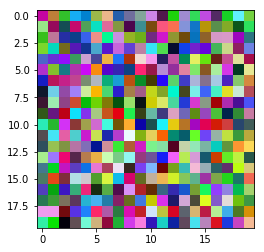

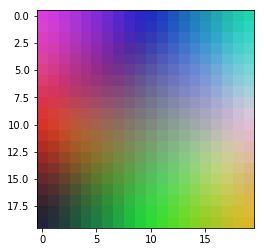

In [17]:
#SOM
import numpy as np
from matplotlib import pyplot as plt

class SOM():

    def __init__(self, teachers, N, seed=None):
        self.teachers = np.array(teachers)
        self.n_teacher = self.teachers.shape[0]
        self.N = N
        if not seed is None:
            np.random.seed(seed)

        x, y = np.meshgrid(range(self.N), range(self.N))
        self.c = np.hstack((y.flatten()[:, np.newaxis],
                            x.flatten()[:, np.newaxis]))
        self.nodes = np.random.rand(self.N*self.N,
                                    self.teachers.shape[1])

    def train(self):
        for i, teacher in enumerate(self.teachers):
            bmu = self._best_matching_unit(teacher)
            d = np.linalg.norm(self.c - bmu, axis=1)
            L = self._learning_ratio(i)
            S = self._learning_radius(i, d)
            self.nodes += L * S[:, np.newaxis] * (teacher - self.nodes)
        return self.nodes

    def _best_matching_unit(self, teacher):
        #compute all norms (square)
        norms = np.linalg.norm(self.nodes - teacher, axis=1)
        bmu = np.argmin(norms) #argment with minimum element 
        return np.unravel_index(bmu,(self.N, self.N))

    def _neighbourhood(self, t):#neighbourhood radious
        halflife = float(self.n_teacher/4) #for testing
        initial  = float(self.N/2)
        return initial*np.exp(-t/halflife)

    def _learning_ratio(self, t):
        halflife = float(self.n_teacher/4) #for testing
        initial  = 0.1
        return initial*np.exp(-t/halflife)

    def _learning_radius(self, t, d):
        # d is distance from BMU
        s = self._neighbourhood(t)
        return np.exp(-d**2/(2*s**2))


N = 20        
teachers = np.random.rand(10000, 3)
som = SOM(teachers, N=N, seed=10)

# Initial map
plt.imshow(som.nodes.reshape((N, N, 3)),
           interpolation='none')
plt.show()

# Train
som.train()

# Trained MAP
plt.imshow(som.nodes.reshape((N, N, 3)),
           interpolation='none')
plt.show()      